In [47]:
import pandas as pd
import numpy as np
import pickle
import finEC.datapreproc as dpp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# %%
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV, train_test_split
from xgboost import XGBRegressor

In [28]:
# loading data

df=pd.read_csv("../data/stock_prices_yahoo.csv",parse_dates=["Date"])

# %%
ec=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec=ec.reset_index()
events=ec[['symbol','date','quarter','year']]
events['date']=pd.to_datetime(events.date)
events.sort_values(['symbol','date'],inplace=True)

# %%
sp500=pd.read_csv("../data/SP500HistoricalData.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500latest=pd.read_csv("../data/HistoricalData_1686903580615.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500=pd.merge(sp500,sp500latest,how="outer",on="Date")

# %%
sp500=sp500[['Date','Price','Close/Last']]
sp500['Price'].fillna(sp500['Close/Last'], inplace=True)
sp500.drop(columns=['Close/Last'],inplace=True)
#rename the columns
sp500.columns=['Date','SP500']
sp500['Date']=pd.to_datetime(sp500.Date)
sp500.sort_values('Date',inplace=True)
sp500['pct_change_sp500'] = sp500['SP500'].pct_change()


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [29]:
df1=df.merge(sp500,how="left",on="Date")
df1.info()
df1.Date.min(),df1.Date.max()
df1 = df1.sort_values(['Ticker', 'Date'])
df1['pct_change_close'] = df1.groupby('Ticker')['Close'].pct_change()

pd.options.mode.chained_assignment = None  # default='warn'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44096 entries, 0 to 44095
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        44096 non-null  int64         
 1   index             44096 non-null  int64         
 2   Date              44096 non-null  datetime64[ns]
 3   Open              44096 non-null  float64       
 4   High              44096 non-null  float64       
 5   Low               44096 non-null  float64       
 6   Close             44096 non-null  float64       
 7   Adj Close         44096 non-null  float64       
 8   Volume            44096 non-null  int64         
 9   Ticker            44096 non-null  object        
 10  SP500             44096 non-null  float64       
 11  pct_change_sp500  44096 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 4.4+ MB


In [30]:
# %%
#implementing the event study methodology
#first, we need to create the event window
#we will use the 2 
for ticker in df1.Ticker.unique():
    df=df1[df1.Ticker==ticker]
    event_dates=events[events.symbol==ticker].date.to_list()
        
    # Define the event window
    event_window = 2

    # Initialize a list to store the abnormal returns
    abnormal_returns_pre = []
    abnormal_returns_event = []
    abnormal_returns_post = []
    allCAR1=[]
    allCAR2=[]
    allMAR1=[]
    allMAR2=[]
    pre_event_window = 100
    post_event_window = 30
    # Iterate over the event dates
    for event_date in event_dates:
        # Filter the data within the event window
        event_start = event_date - pd.Timedelta(days=event_window)
        event_end = event_date + pd.Timedelta(days=event_window)
        
        event_data = df[(df['Date'] >= event_start) & (df['Date'] <= event_end)]

        # Filter the data before the event
        pre_event_start = event_start - pd.Timedelta(days=pre_event_window)
        pre_event_data = df[(df['Date'] >= pre_event_start) & (df['Date'] < event_start)]
        #dropna
        pre_event_data.dropna(inplace=True)

        #pead
        post_event_end = event_end + pd.Timedelta(days=post_event_window)
        post_event_data = df[(df['Date'] > event_end) & (df['Date'] <= post_event_end)]
        # Fit the linear regression model using the market model
        X = pre_event_data['pct_change_sp500'].values.reshape(-1, 1)  # Replace 'Market Return' with your market return column
        y = pre_event_data['pct_change_close'].values.reshape(-1, 1)  # Replace 'Stock Return' with your stock return column
        model = LinearRegression()
        model.fit(X, y)

        # Predict stock returns for each day in the event window
        X_event = event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns = model.predict(X_event)

        # Compute abnormal returns for each day in the event window
        actual_returns = event_data['pct_change_close'].values
        abnormal_returns_event.extend(actual_returns - predicted_returns.flatten())
        #compute cumulative abnormal returns
        CAR1 = np.sum(abnormal_returns_event)
        allCAR1.append(CAR1)
        #compute mean abnormal returns
        MAR1 = np.mean(abnormal_returns_event)
        allMAR1.append(MAR1)

        #compute the abnormal returns for the pre event window
        X_pre = pre_event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns_pre = model.predict(X_pre)
        actual_returns_pre = pre_event_data['pct_change_close'].values
        abnormal_returns_pre.extend(actual_returns_pre - predicted_returns_pre.flatten())

        #compute the abnormal returns for the post event window
        X_post = post_event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns_post = model.predict(X_post)
        actual_returns_post = post_event_data['pct_change_close'].values
        abnormal_returns_post.extend(actual_returns_post - predicted_returns_post.flatten())
        #compute cumulative abnormal returns
        CAR2 = np.sum(abnormal_returns_post)
        allCAR2.append(CAR2)
        #compute mean abnormal returns
        MAR2 = np.mean(abnormal_returns_post)
        allMAR2.append(MAR2)

    events.loc[events.symbol==ticker,'CAR1']=allCAR1
    events.loc[events.symbol==ticker,'CAR2']=allCAR2
    events.loc[events.symbol==ticker,'MAR1']=allMAR1
    events.loc[events.symbol==ticker,'MAR2']=allMAR2
    # join the abnormal returns with the daily stock returns
    # df1[df1.Ticker==ticker][(df1['Date'] >= pre_event_start) & (df1['Date'] <= post_event_end)]['abnormalreturn']=abnormal_returns_pre + abnormal_returns_event+abnormal_returns_post



In [31]:
# creating the relative for the EPS

# %%
# importing the data

df = pd.read_csv('../data/stock_prices_ec.csv',parse_dates=['Date'])

df['eps_surprise'] = (df['eps_mean_report'] / df['eps_mean']) - 1
df=df.merge(events, how='left', left_on=['Ticker', 'Date'], right_on=['symbol', 'date'])

# %%
#adding one hot encoding for the years 2008 and 2020
df['year_2008'] = np.where(df['year'] == 2008, 1, 0)
df['year_2020'] = np.where(df['year'] == 2020, 1, 0)
#adding one hot encoding for the quarters
df['quarter_1'] = np.where(df['quarter'] == 1, 1, 0)
df['quarter_2'] = np.where(df['quarter'] == 2, 1, 0)
df['quarter_3'] = np.where(df['quarter'] == 3, 1, 0)
df['quarter_4'] = np.where(df['quarter'] == 4, 1, 0)
#adding one hot encoding for the different tickers using the get_dummies function
df=pd.get_dummies(df, columns=['Ticker'], prefix=['Ticker'])

In [32]:


# %%
# defining features
#targets are CAR1, CAR2 cumulative abnormal returns and MAR1,MAR2 mean abnormal returns
#CAR2 is the best target. CAR1 is the cumulative abnormal returns for the event window and CAR2 is the cumulative abnormal returns for the post event window
target = ['CAR2']

identification = ['Date', 'Ticker']
dummies=['Ticker_ABBV', 'Ticker_AZN',
       'Ticker_BMY', 'Ticker_JNJ', 'Ticker_LLY', 'Ticker_MRK', 'Ticker_NVO',
       'Ticker_NVS', 'Ticker_PFE', 'Ticker_ROG']
# dummies=['year_2008','year_2020','quarter_1','quarter_2','quarter_3','quarter_4','Ticker_ABBV', 'Ticker_AZN',
#        'Ticker_BMY', 'Ticker_JNJ', 'Ticker_LLY', 'Ticker_MRK', 'Ticker_NVO',
#        'Ticker_NVS', 'Ticker_PFE', 'Ticker_ROG']
surprise = ['eps_surprise']

technical_features = ['rsi5', 'rsi14', 'rsi50', 'rsi200', 'por_change_1_week_val', 'por_change_1_month_val', 'por_change_1_quater_val', 'por_change_1_year_val']

topic_features = ['t1', 't2', 't3', 't4', 't5', 't6' ] # how much of the topic is there on the document
topic_features_d = ['t1d', 't2d', 't3d', 't4d', 't5d', 't6d'] # how much of the topic is there on the document and in which direction (if it's positive or negative)
topic_features_dg = ['t1dg', 't2dg', 't3dg', 't4dg', 't5dg', 't6dg'] # topic_features_d + if they are talking in the short term or long term




In [33]:
# ### Linear Model
# train test split
df = df.dropna()


X = df[surprise+dummies] # model with technical features and surprise
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000) #splitting randomly, it's correct?

                            OLS Regression Results                            
Dep. Variable:                   CAR2   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     62.05
Date:                Sat, 17 Jun 2023   Prob (F-statistic):           1.39e-70
Time:                        16:49:03   Log-Likelihood:                 154.64
No. Observations:                 351   AIC:                            -287.3
Df Residuals:                     340   BIC:                            -244.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0102      0.010      0.980   

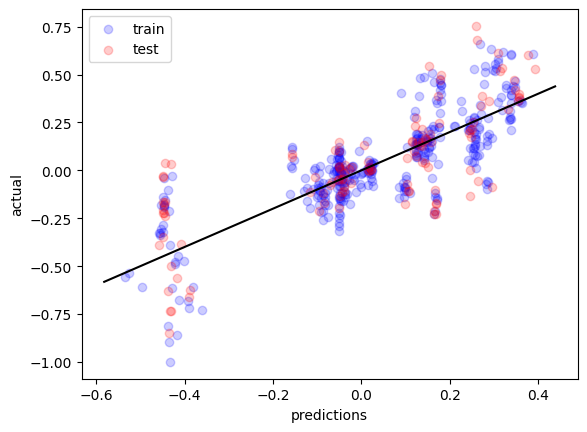

In [34]:
# LINEAR MODELS

# Add a constant to the features
X_train1 = sm.add_constant(X_train)
X_test1 = sm.add_constant(X_test)

# Create the linear model and complete the least squares fit
model = sm.OLS(y_train, X_train1)
results = model.fit()  # fit the model
print(results.summary())

print(results.pvalues)


# Make predictions from our model for train and test sets
train_predictions = results.predict(X_train1)
test_predictions = results.predict(X_test1)

# %%
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, y_train, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()


Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 7, 'random_state': 2000}
DecisionTree_Regressor RMSE score on train sample: 0.1692888022629364
Grid-Searching for model RandomForest_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascost

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 8, 'n_estimators': 100, 'random_state': 2000}
RandomForest_Regressor RMSE score on train sample: 0.17632215230210396
Grid-Searching for model AdaBoost_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 1, 'loss': 'linear', 'n_estimators': 100, 'random_state': 2000}
AdaBoost_Regressor RMSE score on train sample: 0.17180261180027762
Grid-Searching for model GradientBoosting_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 5, 'n_estimators': 100, 'random_state': 2000}
GradientBoosting_Regressor RMSE score on train sample: 0.14026154521808393


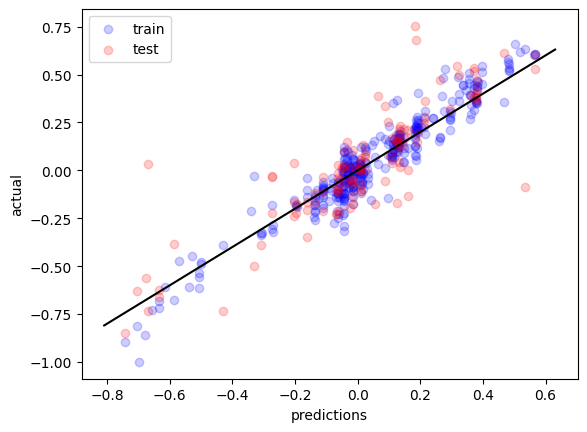

In [35]:

# Machine Learning methods

SEED = 2000
# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_root_mean_squared_error', verbose = 0) #using RMSE as metric for scoring
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} RMSE score on train sample: {-best_model.best_score_}')

# %%
# getting the predictions for the best model
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

plt.scatter(train_predictions, y_train, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  
plt.show()


## Doing it via functions

In [53]:
# defining all the functions to run all the models

def OLS_model(X_train, X_test, y_train):
    # Add a constant to the features
    X_train1 = sm.add_constant(X_train)
    X_test1 = sm.add_constant(X_test)

    # Create the linear model and complete the least squares fit
    model = sm.OLS(y_train, X_train1)
    results = model.fit()  # fit the model

    # Make predictions from the model for train and test sets
    test_predictions = results.predict(X_test1)

    return test_predictions


def elastic_net_model(X_train, X_test, y_train, alpha=0.5, l1_ratio=0.5):
    # Create the Elastic Net model
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    # Fit the model on the training data
    elastic_net.fit(X_train, y_train)

    # Make predictions on the train and test sets
    train_predictions = elastic_net.predict(X_train)
    test_predictions = elastic_net.predict(X_test)

    return test_predictions



def ML_model(X_train, X_test, y_train):
    SEED = 2000

    # models
    models = [XGBRegressor(),
              DecisionTreeRegressor(),
              RandomForestRegressor(),
              AdaBoostRegressor(),
              GradientBoostingRegressor()]

    # models parameters
    xgb_params = {'objective': ['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda': [1.5],
                  'seed': [SEED]}

    dectree_params = {'max_features': range(4, 10),
                      'max_depth': range(3, 6),
                      'min_samples_leaf': range(5, 10),
                      'random_state': [SEED]}

    randomforest_params = {'max_features': range(4, 10),
                           'n_estimators': [50, 100],
                           'max_depth': range(3, 6),
                           'min_samples_leaf': range(5, 10),
                           'random_state': [SEED]}

    adab_params = {'learning_rate': [0.05, 1],
                   'n_estimators': [50, 100],
                   'loss': ['linear', 'square'],
                   'random_state': [SEED]}

    gb_params = {'learning_rate': [0.05, 1],
                 'n_estimators': [50, 100],
                 'max_depth': range(3, 6),
                 'max_features': range(4, 10),
                 'random_state': [SEED]}

    params = [xgb_params, dectree_params, randomforest_params, adab_params, gb_params]
    names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
             'GradientBoosting_Regressor']
    scores = {}

    # gridsearch
    for i, model in enumerate(models):
        print(f"Grid-Searching for model {names[i]}...")
        best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5,
                                         scoring='neg_mean_absolute_error', verbose=0)
        best_model.fit(X_train, y_train)
        print(f"Best model fitted")
        # assign the best parameters to the model
        models[i].set_params(**best_model.best_params_)

        print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
        print(f'{names[i]} MAE score on train sample: {-best_model.best_score_}')

    train_predictions_ML = best_model.predict(X_train)
    test_predictions_ML = best_model.predict(X_test)

    return test_predictions_ML


In [37]:

def build_models(combinations, target, df):
    df = df.dropna()
    models = []
    y = df[target]
    
    for i, combination in enumerate(combinations):
        X = df[combination]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000)
        
        # Call the respective model functions for each combination
        y_pred_OLS = OLS_model(X_train, X_test, y_train)
        y_pred_elastic = elastic_net_model(X_train, X_test, y_train, alpha=0.5, l1_ratio=0.5)
        y_pred_ML = ML_model(X_train, X_test, y_train)
        
        # Create a DataFrame for the predictions
        pred_df = pd.DataFrame({'True': y_test['CAR2'], 'OLS': y_pred_OLS,
                                'Elastic': y_pred_elastic, 'ML_model': y_pred_ML})
        
        # Append the DataFrame to the models list
        models.append(pred_df)
        
    return models


In [38]:
df.head()

,Unnamed: 0,Date,Adj Close,Volume,eps_mean,eps_mean_report,sp_500_closeprice,content,10d_close_pct,10d_future_close,10d_future_close_pct,ma5,ma14,ma50,ma200,rsi5,rsi14,rsi50,rsi200,por_change_1_week_val,por_change_1_month_val,por_change_1_quater_val,por_change_1_year_val,ma_5days_1month,ma_10days_1quarter,ma_20days_1year,eps_mean_report_pdif,topic0,topic1,topic2,topic4,topic5,topic3,t1,t2,t3,t4,t5,t6,t1d,t2d,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg,eps_surprise,symbol,date,quarter,year,CAR1,CAR2,MAR1,MAR2,year_2008,year_2020,quarter_1,quarter_2,quarter_3,quarter_4,Ticker_ABBV,Ticker_AZN,Ticker_BMY,Ticker_JNJ,Ticker_LLY,Ticker_MRK,Ticker_NVO,Ticker_NVS,Ticker_PFE,Ticker_ROG
4,4,2014-04-25,33.879078,7289100.0,3.13085,2.99275,186.289993,Operator: Good morning and thank you for stand...,0.012152,35.285534,0.008168,34.201734,33.576038,34.824788,32.772187,61.390025,40.003843,48.411116,53.097360,1.215240,-4.026735,4.137344,11.008172,-4.533099,1.485603,19.582403,-4.410943,0.052113,0.012447,0.570821,0.042669,0.320704,0.0,0.083732,0.021531,0.023923,0.0,0.000000,0.000000,0.016746,0.004785,0.004785,0.0,0.000000,0.0,0.038278,0.004785,0.004785,0.0,0.000000,0.000000,-0.044109,ABBV,2014-04-25,1,2014,0.057896,-0.084619,0.003860,-0.000791,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
5,5,2014-07-25,36.942524,11680900.0,3.15363,2.84150,197.720001,Operator: Good morning and thank you for stand...,-0.031506,36.456261,-0.002647,37.482979,37.728329,37.685947,35.068624,17.843678,30.055660,51.363575,54.522738,-3.150602,-5.178937,2.886699,24.281098,-1.555421,7.375083,26.705423,-9.897483,0.127244,0.098957,0.572758,0.138599,0.062214,0.0,0.150000,0.085714,0.028571,0.0,0.007143,0.000000,0.035714,0.035714,0.007143,0.0,0.000000,0.0,0.064286,0.035714,0.007143,0.0,0.000000,0.000000,-0.098975,ABBV,2014-07-25,2,2014,0.042199,-0.067431,0.002344,-0.000523,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
6,6,2014-10-31,44.412601,15009900.0,3.21007,2.76900,201.660004,Operator: Good morning and thank you for stand...,0.052579,43.040894,-0.006255,42.836531,40.415443,39.879192,36.941751,81.262182,82.368374,61.025640,55.638567,5.257924,8.934115,21.940498,35.210899,10.661242,20.747561,38.313594,-13.740199,0.132570,0.048618,0.579913,0.040093,0.198759,0.0,0.048780,0.022514,0.031895,0.0,0.009381,0.009381,0.003752,0.003752,0.003752,0.0,0.001876,0.0,0.013133,0.011257,0.007505,0.0,0.003752,0.001876,-0.137402,ABBV,2014-10-31,3,2014,0.055800,-0.042950,0.002657,-0.000286,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
7,7,2015-01-30,42.553131,17582500.0,4.44933,4.28900,199.449997,Operator: Good morning and thank you for stand...,-0.033318,40.120514,-0.011704,43.892838,44.451885,46.236913,40.431253,32.550256,31.428893,45.245774,54.948608,-3.331751,-7.085789,-3.868668,28.904343,-8.448427,0.953127,25.537913,-3.603464,0.098106,0.046126,0.585107,0.018257,0.250607,0.0,0.090713,0.010799,0.028078,0.0,0.004320,0.002160,0.015119,0.000000,0.006479,0.0,0.002160,0.0,0.043197,0.004320,0.010799,0.0,0.004320,0.000000,-0.036035,ABBV,2015-01-30,4,2014,0.029295,-0.143431,0.001221,-0.000839,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
8,8,2015-04-23,45.678783,18405300.0,4.21429,3.72000,211.160004,Operator: Good morning and thank you for stand...,0.026522,45.970284,0.001273,45.246529,43.696530,42.053247,41.893519,79.642684,90.879137,61.279687,53.354036,2.652171,11.272543,2.666967,32.139859,8.000254,2.502931,32.997886,-11.728903,0.174720,0.069127,0.550037,0.039673,0.166406,0.0,0.081933,0.018908,0.067227,0.0,0.006303,0.000000,0.010504,0.006303,0.004202,0.0,0.004202,0.0,0.029412,0.006303,0.033613,0.0,0.006303,0.000000,-0.117289,ABBV,2015-04-23,1,2015,0.062322,-0.140247,0.002226,-0.000734,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [58]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("default", category=DataConversionWarning)


In [59]:

# Define the list of combinations and y
combinations = [surprise + technical_features,  # Model 1
                surprise + technical_features + dummies,  # Model 2
                surprise + technical_features + topic_features  # Model 3
               ]
y = df[target]

# Call the function to build the models
model_dfs = build_models(combinations, target, df)

model_dict = {f'Model_{i+1}': model_df for i, model_df in enumerate(model_dfs)}



Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 2000}
XGB_Regressor MAE score on train sample: 0.21260197369771702
Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 7, 'random_state': 2000}
DecisionTree_Regressor MAE score on train sample: 0.2078858276014571
Grid-Searching for model RandomForest_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascost

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 2000}
RandomForest_Regressor MAE score on train sample: 0.19621366170864846
Grid-Searching for model AdaBoost_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 2000}
AdaBoost_Regressor MAE score on train sample: 0.19522943468446466
Grid-Searching for model GradientBoosting_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 5, 'n_estimators': 50, 'random_state': 2000}
GradientBoosting_Regressor MAE score on train sample: 0.20371566121912288
Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 8, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 2000}
XGB_Regressor MAE score on train sample: 0.10337967239956025
Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 7, 'random_state': 2000}
DecisionTree_Regressor MAE score on train sample: 0.13567113471086328
Grid-Searching for model RandomForest_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascost

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 9, 'n_estimators': 50, 'random_state': 2000}
RandomForest_Regressor MAE score on train sample: 0.12284157400165181
Grid-Searching for model AdaBoost_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50, 'random_state': 2000}
AdaBoost_Regressor MAE score on train sample: 0.13496777647301322
Grid-Searching for model GradientBoosting_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 4, 'n_estimators': 100, 'random_state': 2000}
GradientBoosting_Regressor MAE score on train sample: 0.11079241864033115
Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 7, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 2000}
XGB_Regressor MAE score on train sample: 0.22065633919598823
Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 5, 'random_state': 2000}
DecisionTree_Regressor MAE score on train sample: 0.18900975563258232
Grid-Searching for model RandomForest_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascost

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 8, 'min_samples_leaf': 7, 'n_estimators': 100, 'random_state': 2000}
RandomForest_Regressor MAE score on train sample: 0.1826099616054145
Grid-Searching for model AdaBoost_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 2000}
AdaBoost_Regressor MAE score on train sample: 0.1813166609205526
Grid-Searching for model GradientBoosting_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 4, 'n_estimators': 50, 'random_state': 2000}
GradientBoosting_Regressor MAE score on train sample: 0.18085266217579102


### Error Analysis

In [60]:

model_dict['Model_3'].head()

,True,OLS,Elastic,ML_model
227,-0.626090,0.069380,0.038285,-0.088895
150,0.148617,0.022535,0.038361,-0.036872
421,-0.042737,0.095751,0.045480,0.037350
393,-0.060258,0.029900,0.039121,-0.037959
351,0.004559,-0.019436,0.046588,-0.006716


In [66]:


# creating features for direction
for df in model_dict.values():
    for coluna in ['OLS', 'Elastic', 'ML_model']:
        df[f'{coluna}_dir'] = np.where(((df['True'] > 0) & (df[coluna] > 0)) | ((df['True'] < 0) & (df[coluna] < 0)), 1, 0)
        


# creating features for intensity (1 it's more intense, 0 the prediction tends to go to zero)
for df in model_dict.values():
    for coluna in ['OLS', 'Elastic', 'ML_model']:
        df[f'{coluna}_inten'] = np.where(((df['True'] > 0) & (df[coluna] > df['True'])) | ((df['True'] < 0) & (df[coluna] < df['True'])), 1, 0)



In [72]:
for key in model_dict.keys():
    print(key)


Model_1
Model_2
Model_3


In [74]:
print("Percentage of right directions")
for key in model_dict.keys():
    for coluna in ['OLS_dir', 'Elastic_dir', 'ML_model_dir']:
        print(f'{key}, {coluna} - {model_dict[key][coluna].sum()/len(model_dict[key][coluna])}')
    print("--------------------")

Percentage of right directions
Model_1, OLS_dir - 0.5423728813559322
Model_1, Elastic_dir - 0.559322033898305
Model_1, ML_model_dir - 0.5338983050847458
--------------------
Model_2, OLS_dir - 0.7627118644067796
Model_2, Elastic_dir - 0.559322033898305
Model_2, ML_model_dir - 0.8050847457627118
--------------------
Model_3, OLS_dir - 0.5169491525423728
Model_3, Elastic_dir - 0.559322033898305
Model_3, ML_model_dir - 0.6779661016949152
--------------------
